# Delivery-Analysis and Customer Retention

As a restaurant owner, I frequently navigate challenges such as high operational costs, staffing shortages, and tight profit margins. Attracting and retaining customers in a competitive market requires effective marketing strategies and maximizing return on investment (ROI). Furthermore, fluctuations in customer demand, seasonal trends, and broader economic conditions can directly impact revenue.

The objective of this project is to provide data-driven insights to help restaurant owners evaluate the performance of marketing strategies—particularly flyer distribution in targeted neighborhoods—and identify opportunities to improve customer retention. This analysis focuses both on weekly delivery trends and on recognizing customers who have not placed an order within the past six months. 

**The data displayed in these examples have been artifically generated to protect the privacy of customers.**

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from geopy.geocoders import Nominatim
import time
import folium
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from IPython.display import IFrame
from IPython.display import display
import geojson
import geopandas as gpd
from shapely.geometry import Point


#Load the delivery data into 2 different data frames for each year
file_path = 'Data Deliveries.xlsx'
df_2024 = pd.read_excel(file_path, sheet_name='2024')
df_2025 = pd.read_excel(file_path, sheet_name='2025')


# Weekly Deliveries

Here, we calculate the total number of deliveries for each week using data from 2024 and 2025. This allows us to compare year-over-year performance and observe whether deliveries are increasing or decreasing.

From the trends, we observe that deliveries tend to dip at the beginning of each month and peak mid-month. This pattern may be influenced by financial cycles: rent and other major bills are typically due at the start of the month, reducing disposable income, while mid-month aligns with the distribution of government support payments (e.g., income assistance or child tax credits). These insights can be helpful for optimizing staffing and scheduling.

In [143]:
def getWeeklyDeliveries():

    df = pd.concat([df_2024,df_2025], ignore_index=True)

    # Convert Date
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    # Extract year, week number, and start of week
    df['Year'] = df['Date'].dt.year
    df['Week_Num'] = df['Date'].dt.isocalendar().week
    df['Week_Start'] = df['Date'] - pd.to_timedelta(df['Date'].dt.dayofweek, unit='d')  # Start on Sunday

    # Extract month from Week_Start (ensures 1 value per week)
    df['Month'] = df['Week_Start'].dt.strftime('%B')

    # Count weekly deliveries
    weekly_counts = df.groupby(['Year', 'Week_Num']).size().reset_index(name='Deliveries')

    # Create a consistent `Week_Num -> Month` map using earliest week from any year
    month_map = df.groupby('Week_Num')['Month'].first().reset_index()
    df['Year'] = df['Year'].astype(int) #convert year to int from float
    # Pivot the delivery data
    pivot = weekly_counts.pivot(index='Week_Num', columns='Year', values='Deliveries')
    pivot.columns = [f'{col} Deliveries' for col in pivot.columns]
    pivot = pivot.reset_index()

    # Merge in Month label (no duplicates now)
    pivot = pivot.merge(month_map, on='Week_Num', how='left')

    # Reorder columns
    cols = ['Week_Num', 'Month'] + [col for col in pivot.columns if 'Deliveries' in col]
    pivot = pivot[cols]

    # Fill missing weeks with 0
    pivot = pivot.fillna(0).astype({col: 'int' for col in pivot.columns if 'Deliveries' in col})
    
    return pivot

getWeeklyDeliveries()

,Week_Num,Month,2024 Deliveries,2025 Deliveries
0,9,February,30,53
1,10,March,184,151
2,11,March,211,170
3,12,March,204,159
4,13,March,175,186
5,14,April,193,144
6,15,April,191,166
7,16,April,212,174
8,17,April,189,152
9,18,April,183,167


# Neighbourhood Incomes

Understanding the economic profile of our delivery zones is crucial. Using data from the city’s open datasets, we obtained household income statistics by neighborhood. We overlay this information onto a map to visualize income distribution across our delivery area.

[View income_map.html](income_map.html)

In [85]:
# Load GeoJSON neighbourhood data
gdf = gpd.read_file("neighbourhoods.geojson")

# Load CSV with income data
df_income = pd.read_csv("income_data.csv")  

#change the column name to match so you can merge the 2 dataframes
gdf = gdf.rename(columns={'neighbourhood':'Neighbourhood'}) 

# Merge on 'neighbourhood' column
gdf = gdf.merge(df_income, on='Neighbourhood', how='left')

# Check if data merged correctly
print(gdf[['Neighbourhood', 'Income']].head())

# Create folium map centered on Prince George
m = folium.Map(location=[53.9171, -122.7497], zoom_start=11)

# Add neighbourhoods with color based on average income
folium.Choropleth(
    geo_data=gdf,
    name="choropleth",
    data=gdf,
    columns=["Neighbourhood", "Income"],
    key_on="feature.properties.Neighbourhood",
    fill_color="YlGnBu",
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name="Average Income ($)"
).add_to(m)

# Add labels for each neighbourhood
for _, row in gdf.iterrows():
    if row.geometry is not None and not row.geometry.is_empty:
        centroid = row.geometry.centroid
        folium.map.Marker(
            [centroid.y, centroid.x],
            icon=folium.DivIcon(html=f"""
                <div style="
                    font-size: 12px;
                    color: black;
                    background-color: rgba(255, 255, 255, 0.6);
                    padding: 2px 4px;
                    border-radius: 3px;
                    border: 1px solid #999;">
                    {row['Neighbourhood']}<br>${int(row['Income']):,}
                </div>""")
        ).add_to(m)
m
# Save the map
m.save("income_map.html")
IFrame(src='income_map.html',width=700,height=700)

    Neighbourhood  Income
0  Hart Highlands  117718
1   North Nechako  123734
2       West Bowl  100371
3       East Bowl   73572
4  Cranbrook Hill  157139


# Deliveries by Neighbourhoods

Next, we analyze the number of deliveries per neighborhood. Ideally, we want higher delivery volumes in higher-income areas, as these customers typically have greater disposable income—making them a prime target for premium marketing efforts.

However, the data reveals that the West Bowl and East Bowl neighborhoods—among the lowest in household income—have some of the highest delivery counts. This may be due to their proximity to the restaurant or convenience factors. These neighborhoods may also be more price-sensitive and more likely to exhibit churn. We’ll investigate further.

In contrast, Cranbrook Hill, which has the highest average income, shows significantly fewer deliveries. This presents a clear opportunity for targeted marketing efforts in that area.


    Neighbourhood  delivery_count
0  Cranbrook Hill               5
1       East Bowl             557
2  Hart Highlands             348
3   North Nechako             125
4       West Bowl             835


(70000.0, 185000.0)

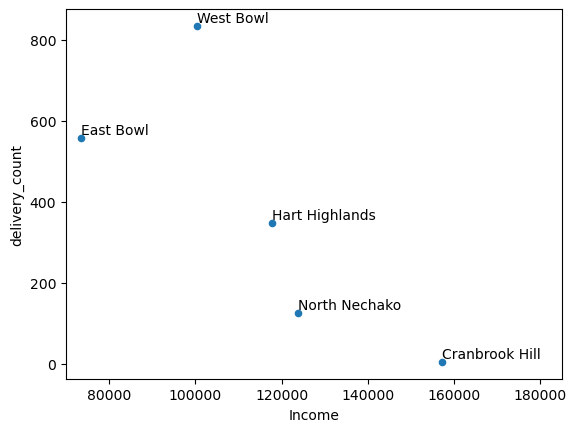

In [144]:
# Load the GeoJSON
gdf = gpd.read_file("neighbourhoods.geojson")

# Load income data
income_df = pd.read_csv("income_data.csv")

# Load delivery data
df_deliveries = pd.read_excel('geocoded_addresses.xlsx')

geometry = [Point(xy) for xy in zip(df_deliveries.longitude, df_deliveries.latitude)]
gdf_deliveries = gpd.GeoDataFrame(df_deliveries, geometry=geometry, crs=gdf.crs)

# Spatial join 
gdf_joined = gpd.sjoin(gdf_deliveries, gdf, how="left", predicate="within") #now each delivery is tagged with the neighbourhoods

# Count deliveries per neighbourhood
delivery_counts = gdf_joined.groupby("neighbourhood").size().reset_index(name="delivery_count")
delivery_counts = delivery_counts.rename(columns={'neighbourhood':'Neighbourhood'})

print(delivery_counts)
# Merge delivery + income
merged_df = delivery_counts.merge(income_df, on="Neighbourhood")
gdf = gdf.rename(columns={'neighbourhood':'Neighbourhood'})


gdf_summary = gdf.merge(merged_df, on="Neighbourhood")
ax = merged_df.plot("Income","delivery_count",kind="scatter")
for idx, row in merged_df.iterrows():
    ax.annotate(row['Neighbourhood'],(row['Income'],row['delivery_count'] + 10))

ax.set_xlim(70000,185000)


# Plotting The Trends

We visualize weekly delivery volumes in 2024 vs. 2025 to assess whether business has grown or slowed. In our case, the data shows a decrease in delivery numbers year-over-year.

This decline may be attributed to several factors—rising interest rates, inflation, or the entrance of new competitors in the area. To understand more, we explore customer churn by identifying those who have not ordered in the last six months.

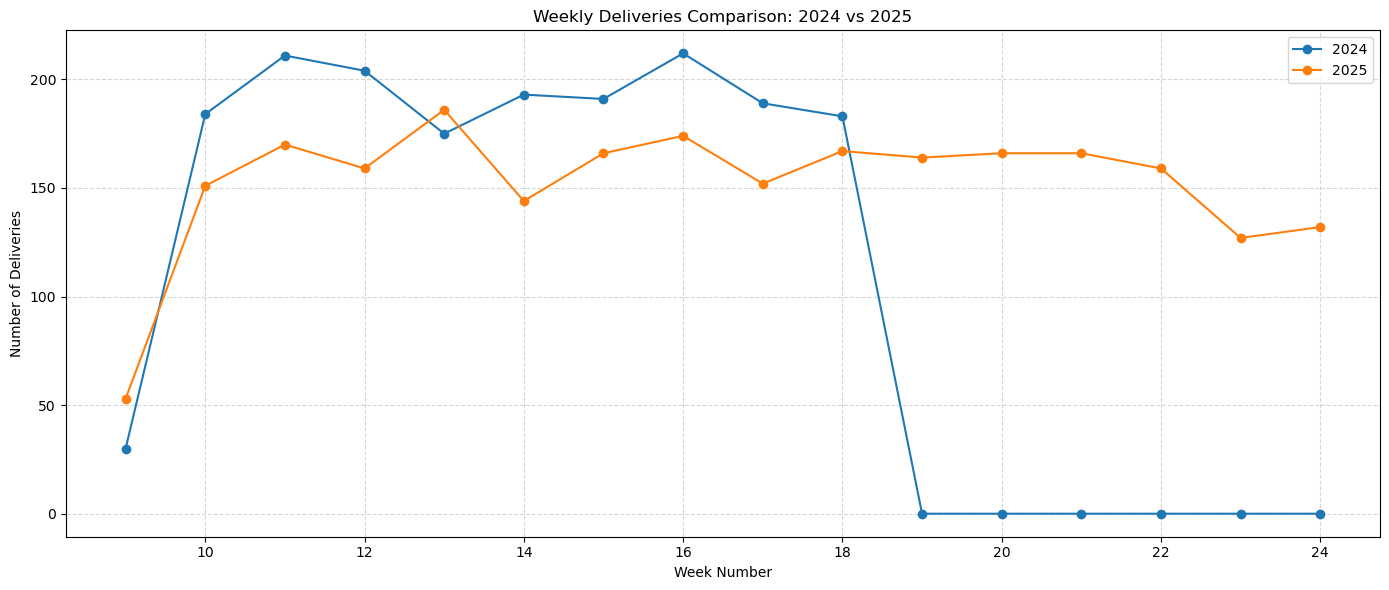

In [145]:
# Plot setup
pivot = getWeeklyDeliveries()
plt.figure(figsize=(14, 6))
plt.plot(pivot['Week_Num'], pivot['2024 Deliveries'], label='2024', marker='o')
plt.plot(pivot['Week_Num'], pivot['2025 Deliveries'], label='2025', marker='o')

plt.title('Weekly Deliveries Comparison: 2024 vs 2025')
plt.xlabel('Week Number')
plt.ylabel('Number of Deliveries')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()



# Inactive Customers 

Identifying inactive customers helps us plan targeted marketing to win them back. We define an inactive customer as someone who:

	•	Has not ordered in the last 6 months.
	•	Previously ordered more than once.

We compile their addresses and average order values into an Excel file. This allows us to tailor promotional offers. For example, a customer with an average order of over $70 may be offered a more substantial discount, as they are likely purchasing for a family and represent higher potential value.


In [84]:
#get inactive customers that have not ordered in the last 6 months
def getInactiveCustomers():
    '''
        Gets the inactive customers that have not ordered in the last 6 months
    '''
    # Combine both DataFrames
    df = pd.concat([df_2024, df_2025], ignore_index=True)

    # Ensure 'date' column is datetime type
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # Remove any rows where date could not be parsed
    df = df.dropna(subset=['Date'])

    # Calculate the date 6 months ago from today
    six_months_ago = datetime.now() - pd.DateOffset(months=6)

    # Get the most recent order date per address
    last_order_per_address = df.groupby('Address')['Date'].max().reset_index()

    # Find addresses where the last order was more than 6 months ago
    inactive_customers = last_order_per_address[last_order_per_address['Date'] < six_months_ago]

    # Merge with original data to get full order history for inactive customers
    merged = pd.merge(inactive_customers[['Address']],df, on='Address',how='left')
    
    # Calculate order counts per address
    order_counts = merged.groupby('Address').size().reset_index(name='order_count')

    # Filter to only those customers who have ordered more than once
    multi_order_customers = order_counts[order_counts['order_count'] > 1]
    
    # Calculate average ticket price for these multi-order inactive customers
    avg_ticket_price = merged[merged['Address'].isin(multi_order_customers['Address'])] \
                    .groupby('Address')['Amount'].mean().reset_index().rename(columns={'Amount': 'avg_ticket_price'})
    

    inactive_customers = pd.merge(avg_ticket_price, last_order_per_address, on='Address')

    #save the inactive customers to excel file
    inactive_customers.to_excel('inactive_customers.xlsx', index=False)

getInactiveCustomers()

# Map Inactive Customers

By mapping inactive customers, we can identify geographic patterns. This helps detect potential impacts of new competitors or economic shifts in certain areas.

As expected, West Bowl and East Bowl have high numbers of inactive customers. This insight can guide targeted discount campaigns in these regions to encourage re-engagement.

[View Inactive Customers.html](Inactive%20Customers.html)

In [86]:
def mapInactiveCustomers():
    '''
        Map the inactive customers to see a visual representation
    '''
    inactive_customers = pd.read_excel('inactive_customers.xlsx')
    addresses = list(inactive_customers['Address'])

    locations = get_locations(addresses)
    
    if locations:
        avg_lat = sum(lat for _, lat, _ in locations) / len(locations)
        avg_lon = sum(lon for _,_, lon in locations) / len(locations)
        m = folium.Map(location=[avg_lat, avg_lon], zoom_start=10)
    
        #add a marker at the specified addresses 
        for addr, lat, lon in locations:
            folium.Marker(location=[lat,lon], popup=addr).add_to(m)
        m.save("Inactive Customers.html")
        print("Map saved as Inactive Customers.html")
    else:
        print("No locations to map.")

#gets latitude and longitude of the address list
def get_locations(addresses):
    
    geolocator = Nominatim(user_agent="address_mapper")
    locations = []
    for address in addresses:
        try:
            location = geolocator.geocode(address)
            if location:
                locations.append((address, location.latitude, location.longitude))
        except Exception as e:
            continue #continue if address cannot be found
            #print(f"Error geocdoing {address}: {e}")
            
        time.sleep(2) #give a 2 second break inbetween api calls so we dont go over the limit of api
        
    return locations

mapInactiveCustomers()
IFrame(src='Inactive Customers.html',width=700,height=700)

Map saved as Inactive Customers.html


# Generate Heat Map

Next, we generate a heat map of deliveries for a selected week. This visualization highlights which areas of the city had the highest order activity. It also helps evaluate whether flyer campaigns in those areas were successful. 

In [6]:
def generateHeatMap(start_of_week):
    
    df = df_2025
    df['Date'] = pd.to_datetime(df['Date'])

    start_date = pd.to_datetime(start_of_week)
    end_date = start_date + timedelta(days=6)

    df_week = df[(df['Date'] >= start_date) & (df['Date'] <= end_date) ]

    addresses = list(df_week['Address'])

    locations = get_locations(addresses)

    df_locations = pd.DataFrame(locations)
    df_locations = df_locations.rename(columns={0:'Address',1:'latitude',2:'longitude'})
    
    #merge the latitude and longitude
    df_week = df_week.merge(df_locations,on='Address',how='left')
    df_week = df_week.dropna(subset=['latitude', 'longitude'])

    map_center = [df_week['latitude'].mean(),df_week['longitude'].mean()]

    m = folium.Map(location=map_center, zoom_start=8)

    #generate heatmap
    heat_data = df_week[['latitude','longitude']]
    HeatMap(heat_data).add_to(m)

    m.save("delivery_heatmap.html")

#gets latitude and longitude of the address list
def get_locations(addresses):
    
    geolocator = Nominatim(user_agent="address_mapper")
    locations = []
    for address in addresses:
        try:
            location = geolocator.geocode(address)
            if location:
                locations.append((address, location.latitude, location.longitude))
        except Exception as e:
            continue #continue if address cannot be found
            #print(f"Error geocdoing {address}: {e}")
            
        time.sleep(2) #give a 2 second break inbetween api calls so we dont go over the limit of api
        
    return locations

generateHeatMap("2025-05-17")

# Heat Map Analysis

Below is the heat map. As shown, deliveries are concentrated in a small section of the city. Several neighborhoods received no orders at all.

By comparing this map with the areas targeted by promotional campaigns, we can assess effectiveness. Neighborhoods with little or no activity could benefit from increased marketing efforts, such as additional flyer distribution.


[View delivery_heatmap.html](delivery_heatmap.html)

In [20]:
IFrame(src='delivery_heatmap.html',width=700,height=700)

# Churn Prediction (Random Forest)

We now use a Random Forest model to predict which customers are at risk of churning. The model assigns a churn probability score to each customer. Any customer with a score of 0.6 or higher is considered at high risk of churning.

These scores are exported to an Excel file for review. Additionally, we generate a classification report to evaluate the model’s performance:

| Metric    |  Meaning
|:----------|:------------------------------------------------------------------------------------------|
|Precision  |   Out of all the customers the model predicted would churn, how many actually did?        |
|Recall	    |   Out of all customers who actually churned, how many did the model correctly identify?   |
|F1-score   |   Harmonic mean of precision and recall — balances the two                                |
|Support    |   The number of actual instances in each class (e.g., how many churned)                   |


    •	Class 0 = Customers who did not churn
    •	Class 1 = Customers who churned


We also calculate the ROC AUC score, which evaluates how well the model distinguishes between churners and non-churners:

|Score |	Meaning                                    |
|:-----|:----------------------------------------------|
|1.0   |    Perfect separation — ideal model           |
|0.95  |	Excellent — almost always right            |
|0.85  |	Very good — ranks most churners correctly  |
|0.70  |	Fair — helpful, but room for improvement   |
|0.50  |	No skill — same as random guessing         |
|< 0.50|	Worse than guessing — probably inverted    |

In our case, the model achieved an ROC AUC score of 1.0, indicating perfect separation between churners and non-churners—an ideal outcome in terms of ranking performance.


In [118]:
def time_to_seconds(t):
    '''
        Convert time (ex, 14:30:00) into seconds since midnight

        Params: 
            The time 
        
        Returns:
            the seconds since midnight
    '''
    if pd.isnull(t):
        return None
    return t.hour * 3600 + t.minute * 60 + t.second


def customerRetention():
    '''
        Uses supervised machine learning (Random Forest Model) to find the likelihood of customer reordering
    '''
    df = pd.concat([df_2024,df_2025], ignore_index=True)
    # Ensure 'date' column is datetime
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])

    # Use April 1, 2025 as reference point
    reference_date = pd.Timestamp('2025-06-01')
    six_months_ago = reference_date - pd.DateOffset(months=6)

    df['time_in_seconds'] = df['Time'].apply(time_to_seconds)

    # Group by customer (address)
    group = df.groupby('Address').agg({
        'Date': ['min', 'max', 'count'],
        'Amount': 'mean',
        'Channel': lambda x: x.value_counts().to_dict(),
        'time_in_seconds': 'mean'
    })

    # Flatten column names
    group.columns = ['first_order', 'last_order', 'total_orders', 'avg_order_amount', 'order_channels', 'avg_order_time']
    group.reset_index(inplace=True)

    # Add days since last order
    group['days_since_last_order'] = (reference_date - group['last_order']).dt.days

    # Create churn label: 1 = churned (no order in last 6 months)       
    group['churn'] = (group['last_order'] < six_months_ago).astype(int)

    # Expand order channels into separate columns
    channels_df = pd.json_normalize(group['order_channels'])
    group = pd.concat([group, channels_df.fillna(0)], axis=1)

    # Final features
    features = ['total_orders', 'avg_order_amount', 'days_since_last_order', 'avg_order_time']
    features += [col for col in ['POS', 'call Center', 'web', 'mobile'] if col in group.columns]

    # Drop rows with missing data in selected features
    X = group[features].fillna(0)
    y = group['churn']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Train Random Forest model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Evaluate model
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    print(classification_report(y_test, y_pred))
    print("ROC AUC Score:", roc_auc_score(y_test, y_prob))

    # Predict churn probability for all customers
    group['churn_probability'] = model.predict_proba(X_scaled)[:, 1]
    group['churn_prediction'] = (group['churn_probability'] >= 0.5).astype(int)

    # Save to Excel
    group[['Address', 'total_orders', 'avg_order_amount', 'days_since_last_order',
        'churn_probability', 'churn_prediction']].to_excel('churn_model_output.xlsx', index=False)

    print("Churn predictions saved to 'churn_model_output.xlsx'")

customerRetention()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       236
           1       1.00      1.00      1.00       116

    accuracy                           1.00       352
   macro avg       1.00      1.00      1.00       352
weighted avg       1.00      1.00      1.00       352

ROC AUC Score: 1.0
Churn predictions saved to 'churn_model_output.xlsx'


# Income vs Churn Rate
We analyze the relationship between churn likelihood and neighborhood income levels, helping identify trends or correlations between economic status and customer retention. We notice that the lower economic neighbourhoods with East Bowl and West Bowl are predicted to have a higher churn.

In [121]:
df = pd.read_excel("churn_model_output.xlsx")
count = (df['churn_prediction'] == 1).sum()

total = len(df)

percentage = (count / total) * 100

print(f"The percentage of customers expected to churn is {percentage:.2f}%")


The percentage of customers expected to churn is 32.40%


    Neighbourhood  churn_count
0  Cranbrook Hill            3
1       East Bowl          154
2  Hart Highlands          115
3   North Nechako           39
4       West Bowl          250


(0.0, 300.0)

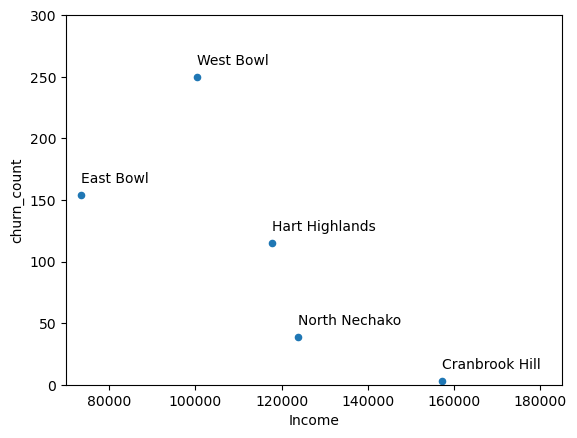

In [140]:
# Load the GeoJSON
gdf = gpd.read_file("neighbourhoods.geojson")

# Load income data
income_df = pd.read_csv("income_data.csv")

# Load delivery data
#to save time we have geocoded the addresses in the churn_rate excel file generated to tag it with neighbourhoods
df_deliveries = pd.read_excel('geocoded_addresses_churn_rate.xlsx')

geometry = [Point(xy) for xy in zip(df_deliveries.longitude, df_deliveries.latitude)]
gdf_deliveries = gpd.GeoDataFrame(df_deliveries, geometry=geometry, crs=gdf.crs)

# Spatial join 
gdf_joined = gpd.sjoin(gdf_deliveries, gdf, how="left", predicate="within") #now each delivery is tagged with the neighbourhoods

#filter out the customers that are expected to churn
churned_customers = gdf_joined[gdf_joined["churn_prediction"] == 1]
#count churned deliveries per neighbourhood
churn_counts = churned_customers.groupby("neighbourhood").size().reset_index(name="churn_count")
churn_counts = churn_counts.rename(columns={'neighbourhood': 'Neighbourhood'})
print(churn_counts)

# Merge delivery + income
merged_df = churn_counts.merge(income_df, on="Neighbourhood")
gdf = gdf.rename(columns={'neighbourhood':'Neighbourhood'})

gdf_summary = gdf.merge(merged_df, on="Neighbourhood")
ax = merged_df.plot("Income","churn_count",kind="scatter")
for idx, row in merged_df.iterrows():
    ax.annotate(row['Neighbourhood'],(row['Income'],row['churn_count'] + 10))

ax.set_xlim(70000,185000)
ax.set_ylim(0,300)



